In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import Series,DataFrame
from lmfit import Model
from numpy import exp

In [2]:
def logistic(t,A,mu,lamb):
    y = A/(1+exp((4*mu/A)*(lamb-t)+2))
    return y

In [3]:
logmod = Model(logistic)

In [4]:
data = pd.ExcelFile('ART_coverage2.xlsx')
dframe = data.parse('Data')
dframe2 = dframe.pivot_table(index='Country Name',columns='Year',values='Value')
dframe2 = dframe2.dropna(axis=0,how='all')
dframe2 = dframe2.dropna(axis=1,how='all')
diff = dframe2.diff(axis=1)
diff.fillna(0,inplace=True)

In [5]:
t = np.arange(0,15)
y = np.asarray(dframe2.ix['Argentina'])

In [6]:
a = 100
mu = diff.ix['Argentina'].max()
lamb = 0

In [7]:
params = logmod.make_params(A=a,mu=mu,lamb=lamb)

In [8]:
logmod.set_param_hint('A',value=dframe2.ix['Argentina'].max(),min=0,max=100)
logmod.set_param_hint('mu',value=diff.ix['Argentina'].max())
logmod.set_param_hint('lamb',value=0)

In [9]:
result = logmod.fit(y,t=t)

 - Adding parameter for hint "A"
 - Adding parameter for hint "mu"
 - Adding parameter for hint "lamb"
 - Adding parameter "A"
 - Adding parameter "mu"
 - Adding parameter "lamb"


In [10]:
print(result.fit_report())

[[Model]]
    Model(logistic)
[[Fit Statistics]]
    # function evals   = 58
    # data points      = 15
    # variables        = 3
    chi-square         = 62.771
    reduced chi-square = 5.231
[[Variables]]
    A:      67.2156532 +/- 10.64317 (15.83%) (init= 58.75)
    mu:     2.16076880 +/- 0.375300 (17.37%) (init= 7.5)
    lamb:  -13.7567870 +/- 2.977166 (21.64%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(mu, lamb)                  =  0.992 
    C(A, mu)                     = -0.888 
    C(A, lamb)                   = -0.847 



In [11]:
plt.plot(t, y,         'bo')
plt.plot(t, result.init_fit, 'k--')
plt.plot(t, result.best_fit, 'r-')
plt.show()

In [12]:
dframe2.index[0]

'Afghanistan'

In [13]:
len(dframe2)

116

In [14]:
### Initialize dictionary
log_dict ={}

In [16]:
### Iterate model build for each country
for i in range(0,len(dframe2)):
    ### Select country
    country = dframe2.index[i]
    ### Select coverage values
    y = np.asarray(dframe2.ix[country])
    ### Set parameter hints
    logmod.set_param_hint('A',value=dframe2.ix[country].max(),min=0,max=100)
    logmod.set_param_hint('mu',value=diff.ix[country].max())
    logmod.set_param_hint('lamb',value=0)
    ### Fit model
    result = logmod.fit(y,t=t,verbose=False)
    ### Store fitted model in dictionary
    log_dict[country] = result

In [19]:
country='Burkina Faso'
y=dframe2.ix[country]
plt.plot(t, y,         'bo')
plt.plot(t, log_dict[country].best_fit, 'r-')
plt.ylabel('ART coverage (%)')
plt.xlabel('Time (in years since 2000)')
plt.show()

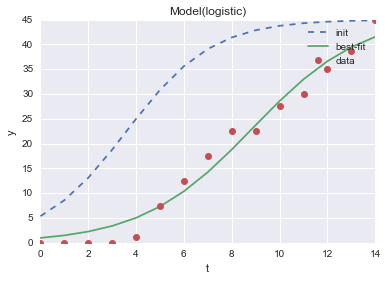

In [25]:
%matplotlib inline
log_dict['Cabo Verde'].plot_fit()

In [18]:
log_dict['Vietnam'].best_values

{'A': 47.821145983913915, 'lamb': 5.9818331742224151, 'mu': 6.9265057469000091}

In [17]:
pop_data = pd.ExcelFile('Total_Population_2015.xlsx')
pop_frame = pop_data.parse('Data')
pop_frame.head()

,Country Name,Total Population (2015)
0,Afghanistan,32527000
1,Albania,2906000
2,Algeria,39667000
3,American Samoa,56000
4,Andorra,70000


In [18]:
pop_frame=pop_frame[pop_frame['Total Population (2015)']>1000000]

In [19]:
len(pop_frame)

191

In [20]:
estFrame = DataFrame(columns=['Country Name','A','lamb','mu','AIC','BIC'])

In [21]:
for country in log_dict:
    dic = log_dict[country].best_values
    dic['Country Name'] = country
    dic['AIC']=log_dict[country].aic
    dic['BIC']=log_dict[country].bic
    estFrame = estFrame.append(dic,ignore_index=True)

In [22]:
best_est = pd.merge(estFrame,pop_frame,how='inner',
                   left_on='Country Name',right_on='Country Name',sort=True)

In [23]:
best_est.head()

,Country Name,A,lamb,mu,AIC,BIC,Total Population (2015)
0,Afghanistan,4.645488,9.347052,1.464471,-36.163328,-34.039177,32527000
1,Algeria,99.804360,-5.413566,-29.739359,114.571053,116.695203,39667000
2,Angola,40.612634,6.708837,4.235012,17.439057,19.563207,25022000
3,Arab World,26.765732,5.481151,2.344164,-15.664032,-13.539882,393433000
4,Argentina,67.215653,-13.756787,2.160769,30.818804,32.942955,43417000


In [27]:
writer = pd.ExcelWriter('Logistic_Estimates.xlsx')
best_est.to_excel(writer)
writer.save()

In [28]:
lmi = pd.ExcelFile('LMI_Countries.xlsx')
lmi = lmi.parse('Sheet1')

In [29]:
lmi_est = pd.merge(best_est,lmi,how='inner',
                   left_on='Country Name',right_on='Country Name',sort=True)

In [30]:
lmi_est.head()

,Country Name,A,lamb,mu,AIC,BIC,Total Population (2015),Code,Group Name,Country Code
0,Afghanistan,4.645488,9.347052,1.464471,-36.163328,-34.039177,32527000,LMY,Low & middle income,AFG
1,Algeria,99.804360,-5.413566,-29.739359,114.571053,116.695203,39667000,LMY,Low & middle income,DZA
2,Angola,40.612634,6.708837,4.235012,17.439057,19.563207,25022000,LMY,Low & middle income,AGO
3,Armenia,40.410400,8.472485,4.245944,-17.632477,-15.508326,3018000,LMY,Low & middle income,ARM
4,Azerbaijan,56.260456,10.241360,7.270743,-22.043126,-19.918975,9635000,LMY,Low & middle income,AZE


In [31]:
writer2 = pd.ExcelWriter('LMI_Estimates_Logistic.xlsx')
lmi_est.to_excel(writer2)
writer2.save()

In [32]:
lmi_est['ART Coverage (2014)'] = dframe2[2014]

In [33]:
cov = DataFrame.from_dict(dframe2[2014]).reset_index(level=0)

In [34]:
cov_est = pd.merge(lmi_est,cov,how='inner',
                   left_on='Country Name',right_on='Country Name',sort=True)

In [39]:
cov_est.head()

,Country Name,A,lamb,mu,AIC,BIC,Total Population (2015),Code,Group Name,Country Code,ART Coverage (2014),ART Coverage (2014)
0,Afghanistan,4.645488,9.347052,1.464471,-36.163328,-34.039177,32527000,LMY,Low & middle income,AFG,NaN,5.00
1,Algeria,99.804360,-5.413566,-29.739359,114.571053,116.695203,39667000,LMY,Low & middle income,DZA,NaN,71.25
2,Angola,40.612634,6.708837,4.235012,17.439057,19.563207,25022000,LMY,Low & middle income,AGO,NaN,31.25
3,Armenia,40.410400,8.472485,4.245944,-17.632477,-15.508326,3018000,LMY,Low & middle income,ARM,NaN,23.75
4,Azerbaijan,56.260456,10.241360,7.270743,-22.043126,-19.918975,9635000,LMY,Low & middle income,AZE,NaN,27.50


In [36]:
cov_est.rename(columns={2014:'ART Coverage (2014)'},inplace=True)

In [40]:
writer3 = pd.ExcelWriter('Coverage and Estimates - Logistic.xlsx')
cov_est.to_excel(writer3)
writer3.save()